<a href="https://colab.research.google.com/github/RatchanonPa/python_dataviz2024/blob/main/final_dataviz_2024_653020217_4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

โหลดข้อมูล Metabolites จำนวน 51 samples จาก https://drive.google.com/drive/folders/18BGc4-dxHwuSB6ep3PmHa688Fiww23CI?usp=sharing
ซี่งประกอบด้วยค่า X ขนาด 51x65536 ซึ่งเป็นค่าความเข้มข้นขององค์ประกอบ และ ppm ขนาด 65536 ซึ่งเป็นค่า Chemical shift
ดังรูป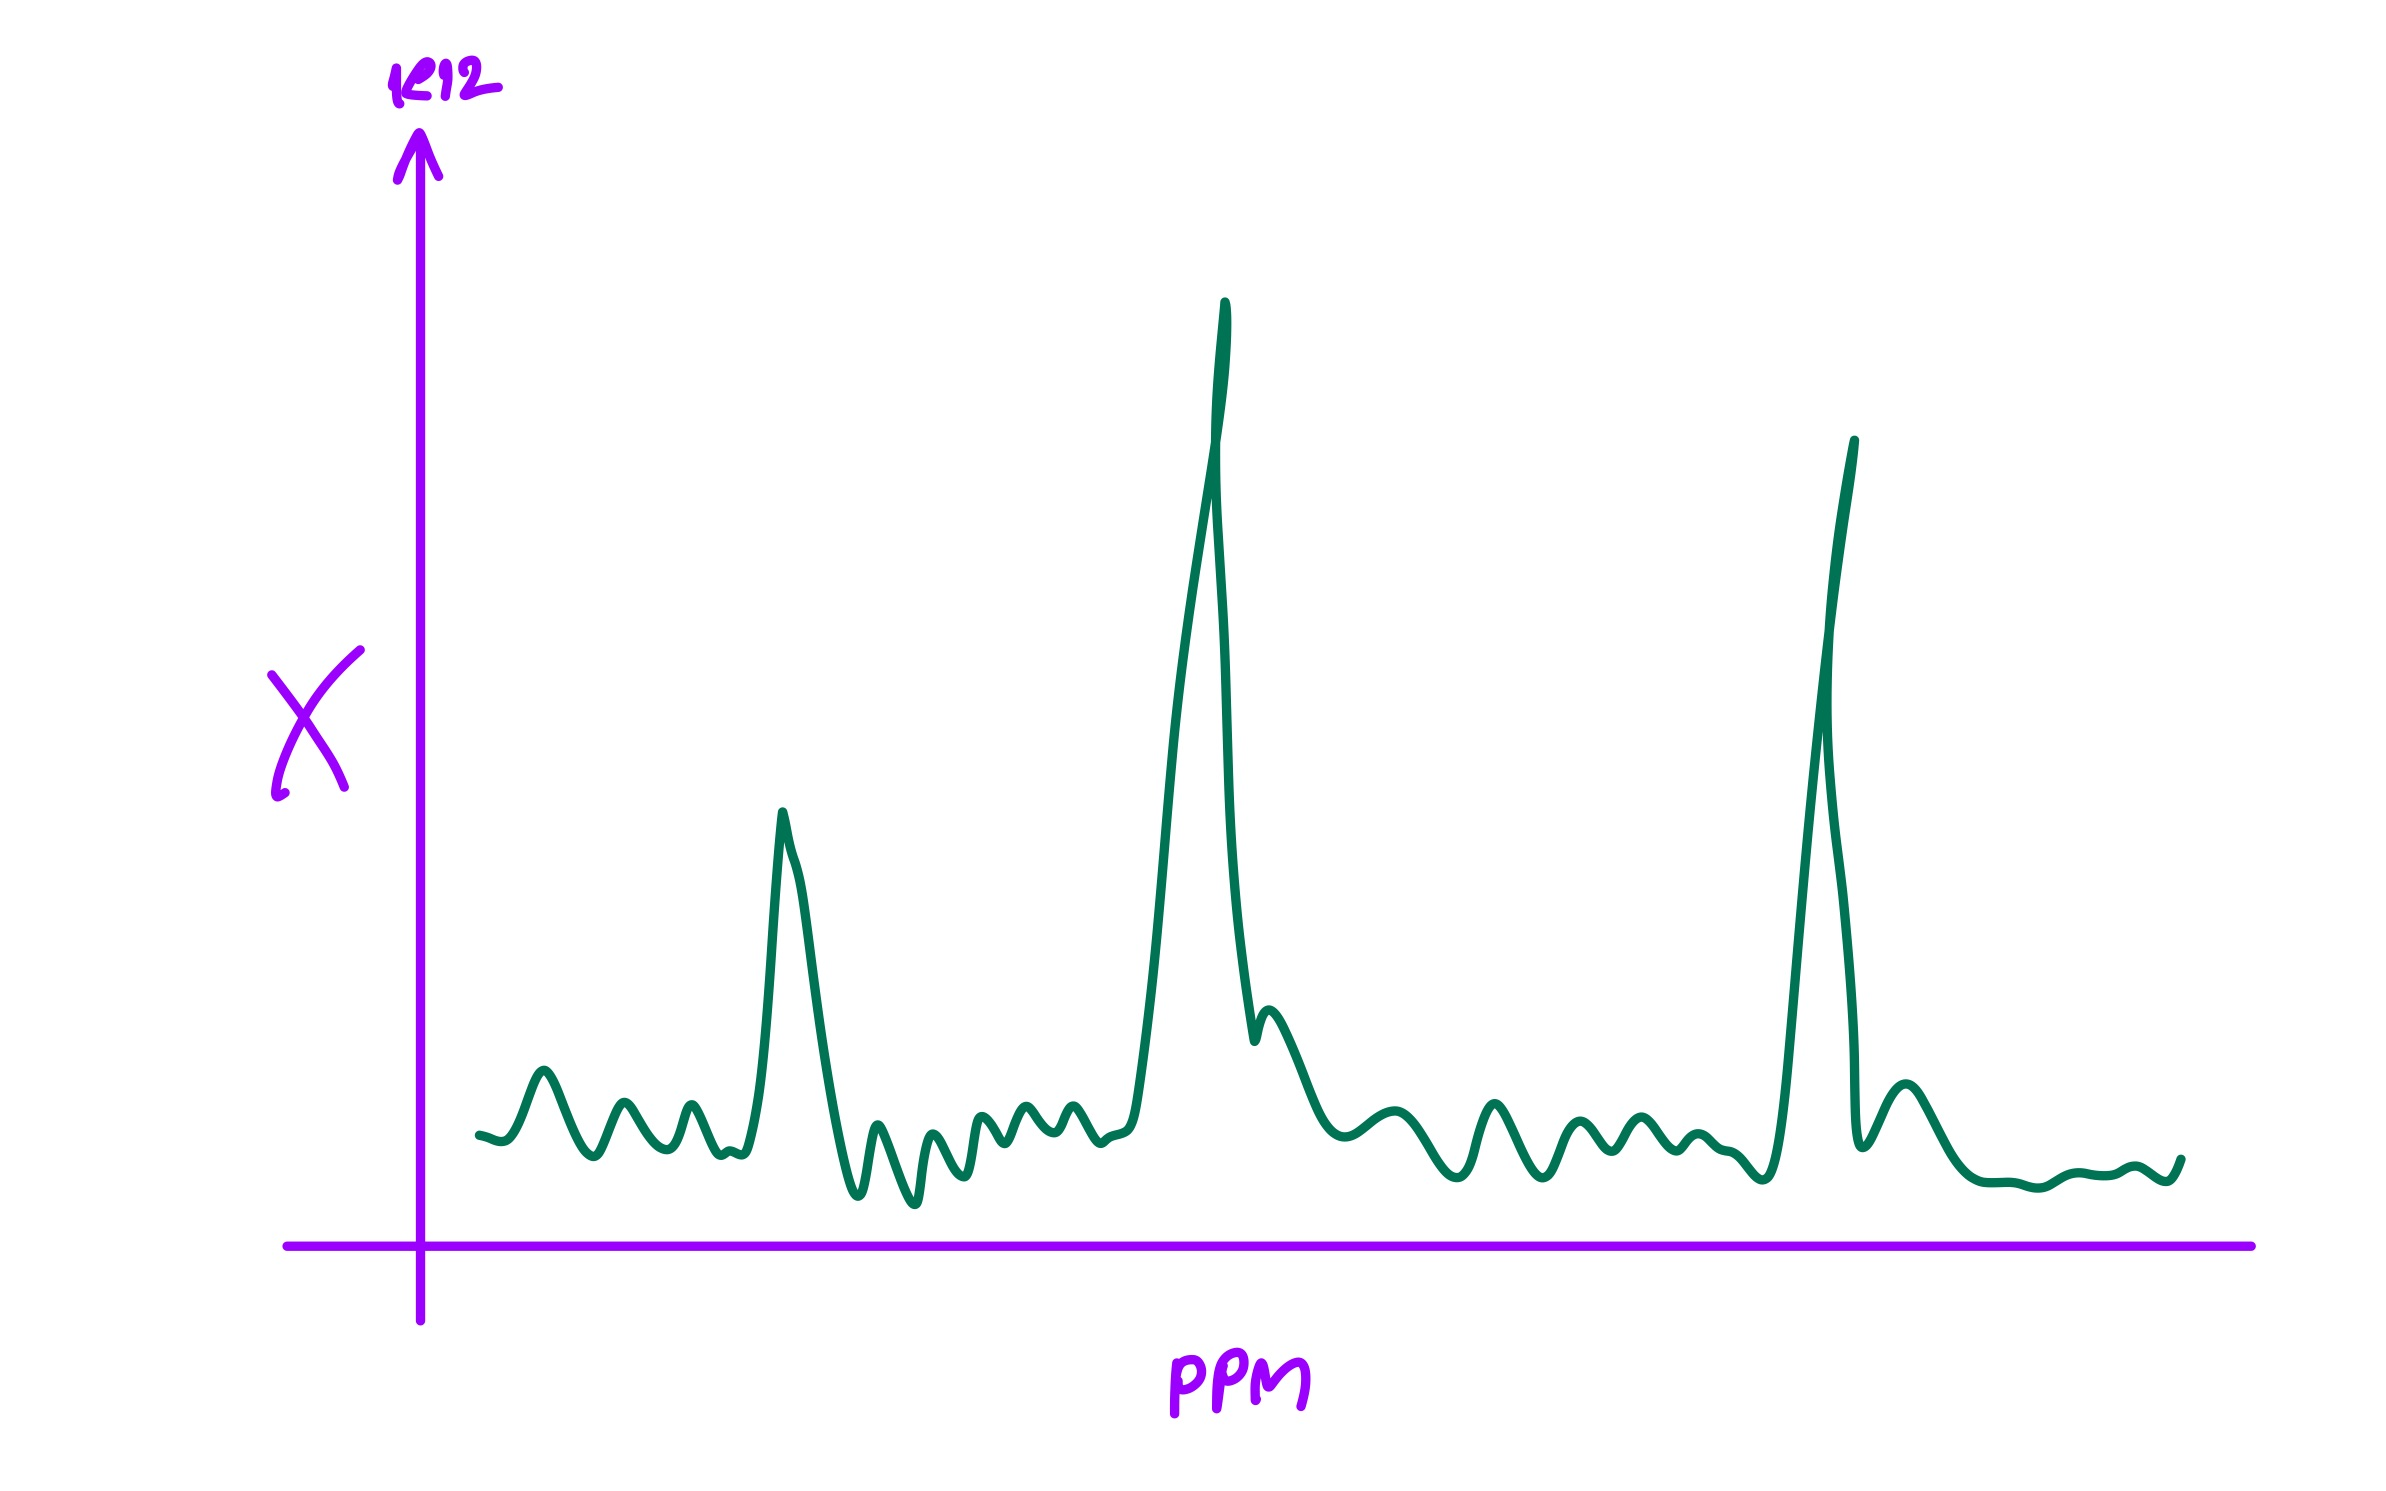

จัดการข้อมูลโดย 1 ตัด ข้อมูลที่อยู่นอกช่วงที่สนใจ (ppm $\leq$ 0 และ ppm $\geq$ 9.5)
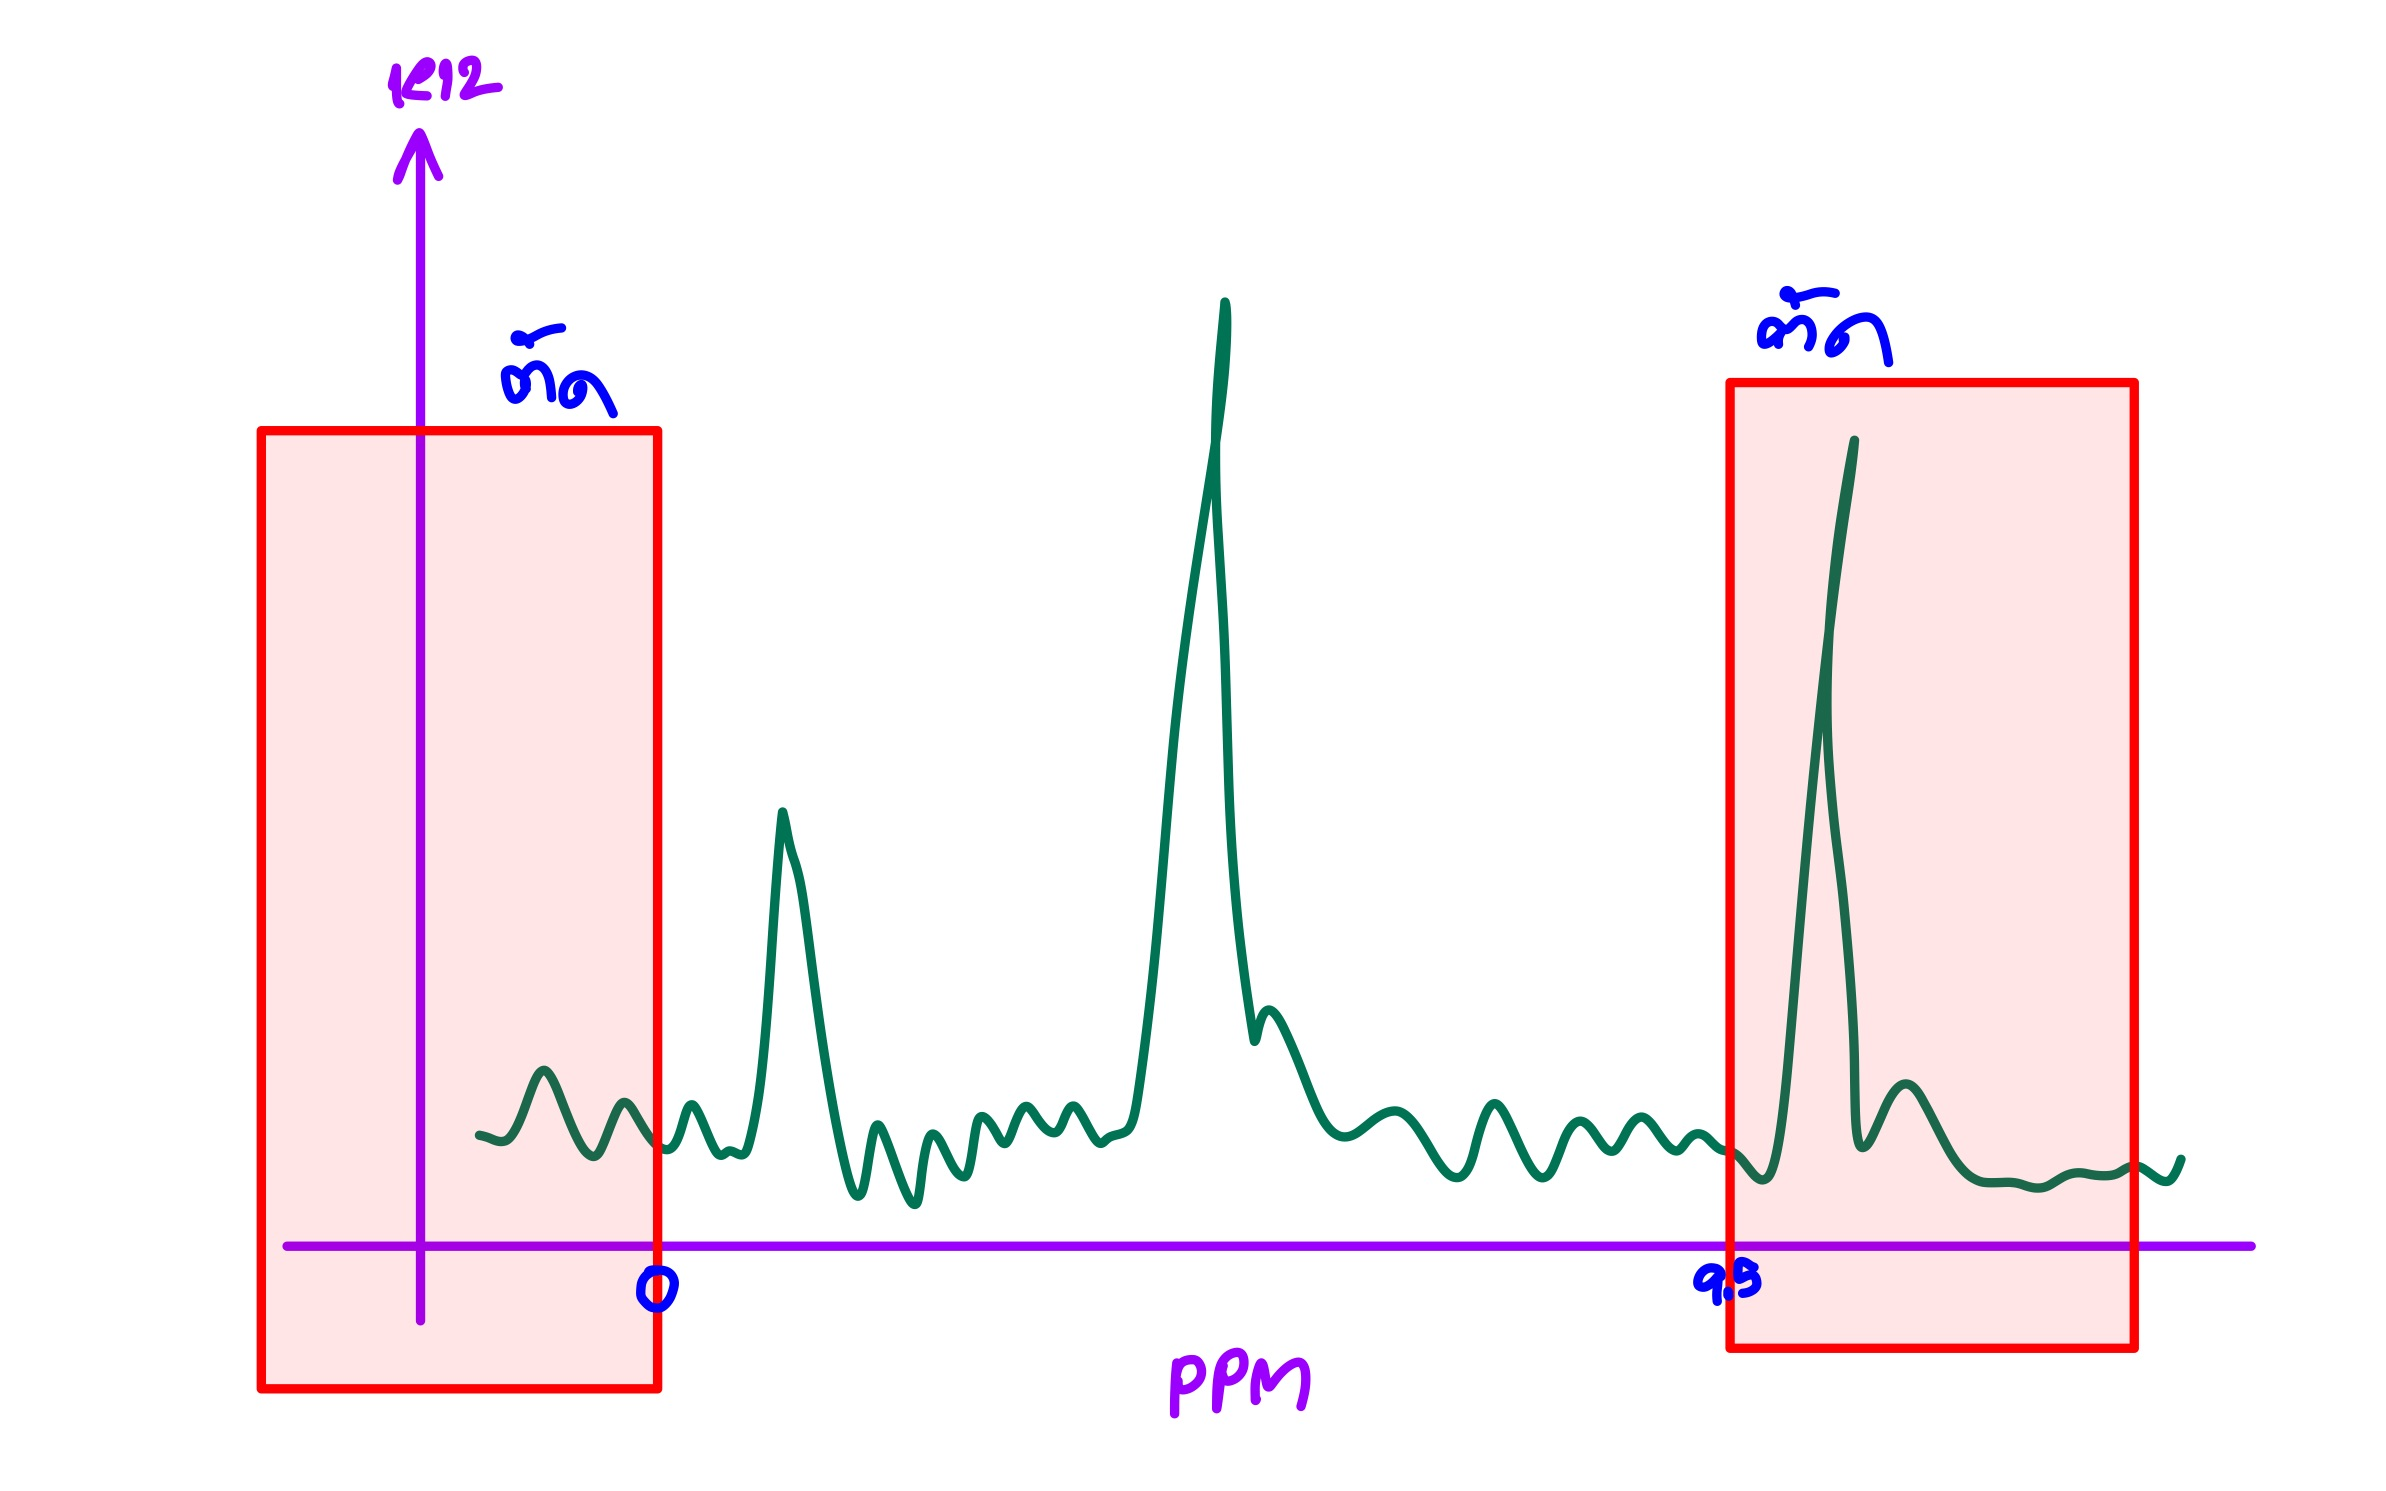

และ 2 quantize ข้อมูลโดยลดจำนวนข้อมูล ให้เหลือเพียง 51 x 400 โดยรวมข้อมูลที่อยู่ข้างกันและเลือกค่า max X
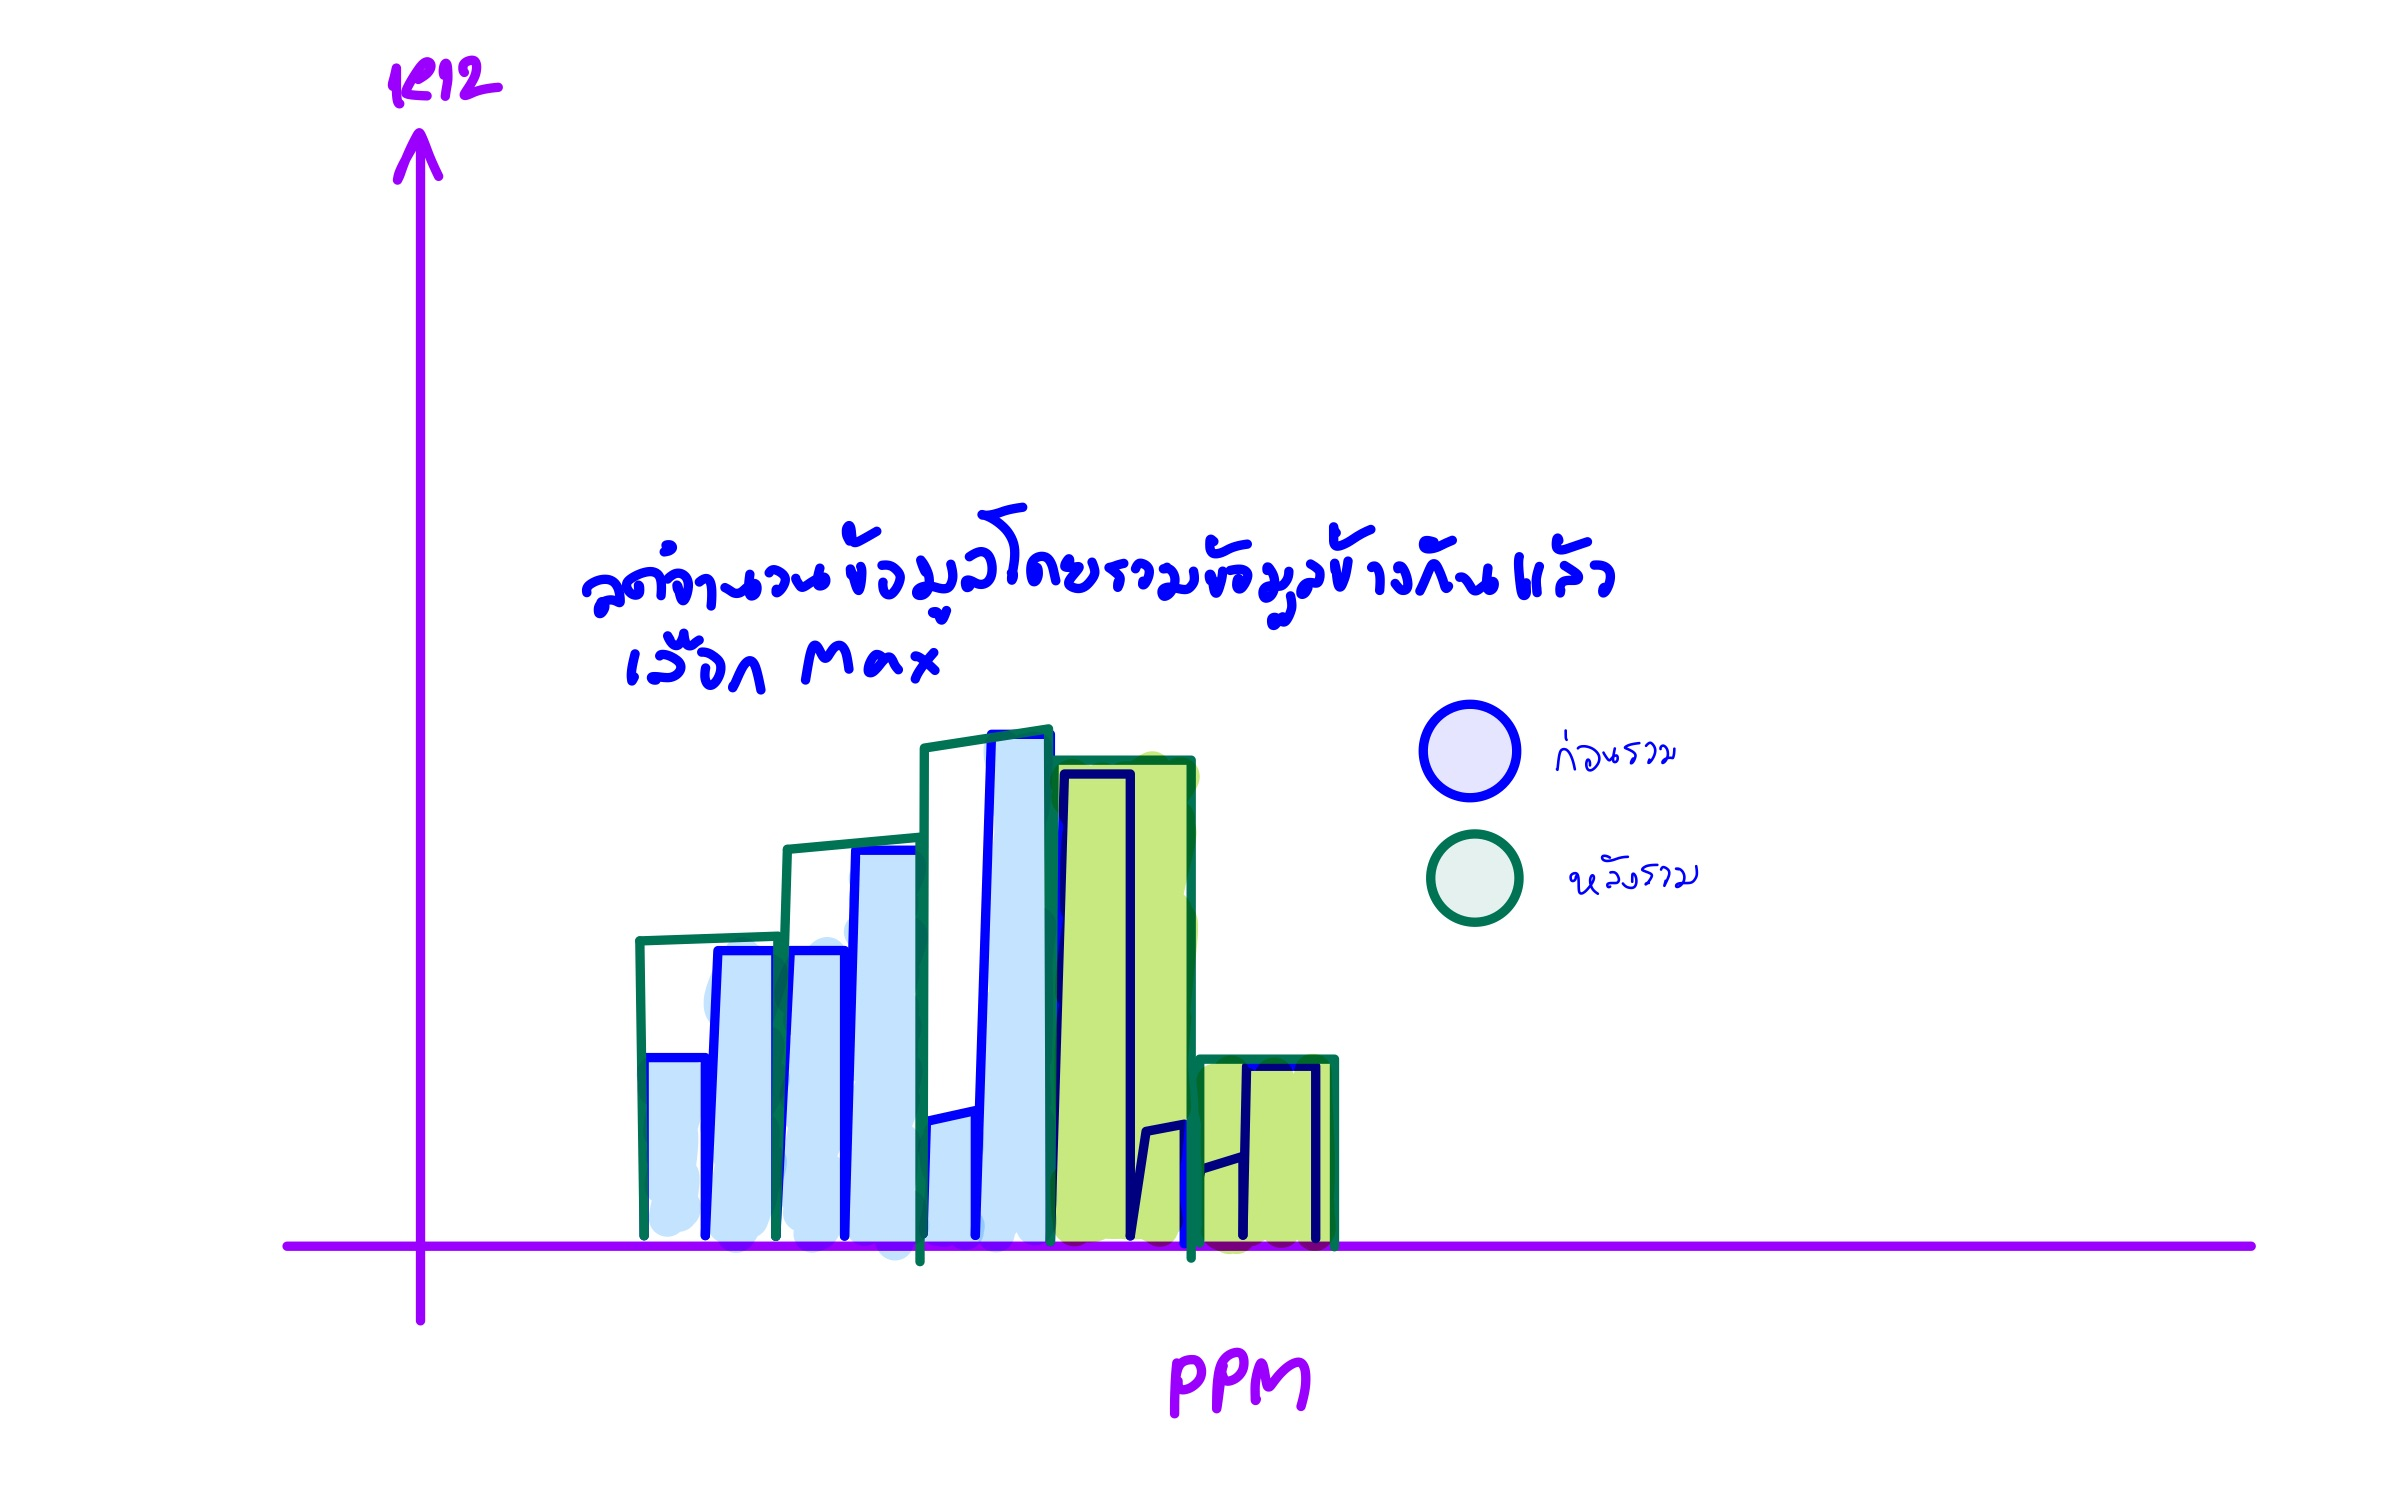

ข้อสอบ
0. preprocess ข้อมูลตามคำแนะนำข้างบน
1. ทำ PCA ข้อมูลเพื่อให้สามารถ visualize ได้
2. visualize ข้อมูลทั้ง 51 จุด เพื่อดูการจัดกลุ่มของข้อมูลเบื้องต้น
3. ตอบคำถามว่า data มีทั้งหมดกี่กลุ่ม โดย plot จุดข้อมูลแต่ละกลุ่มเป็นคนละสี
4. สร้าง ตารางที่มี column บอกว่า data แต่ละจุดนั้นอยู่กลุ่มไหน

# 0) Data Preprocessing

##  Import Packages

In [91]:
import pandas as pd
import pickle
import numpy as np
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from google.colab import drive

## Data Loading

In [57]:
# Mount Google Drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [58]:
# Path to the pickle file
file_path = '/content/drive/MyDrive/data_viz_2024_DATA/Xnn_ppm.pickle'

# Open the pickle file in binary mode
with open(file_path, 'rb') as f:
    data = pickle.load(f)

# Process the data as needed
data

(array([[ 1.36984969e+07,  1.36904279e+07,  1.27889682e+07, ...,
          1.88668440e+06,  3.11779437e+06,  3.34950400e+06],
        [ 8.55679993e+06,  7.90758455e+06,  7.28975667e+06, ...,
          1.36576000e+06,  1.36576000e+06,  1.36576000e+06],
        [ 4.74035200e+06,  4.74035200e+06,  4.74035200e+06, ...,
         -2.02200274e+06, -2.32252840e+06, -3.07843664e+06],
        ...,
        [ 3.86329400e+07,  3.86329400e+07,  3.86329400e+07, ...,
         -4.37613458e+08, -4.38095321e+08, -4.40187284e+08],
        [ 9.94168277e+05,  9.94168277e+05,  9.94168277e+05, ...,
         -4.62360904e+05,  4.27633911e+05, -1.72847014e+06],
        [-1.41491086e+05, -1.41491086e+05, -1.41491086e+05, ...,
          1.16130230e+07,  1.16073431e+07,  8.35909427e+06]]),
 array([10.87128   , 10.87109488, 10.87090976, ..., -1.26026981,
        -1.26045493, -1.26064005]))

In [59]:
# Step 1: Load the pickle file
file_path = '/content/drive/MyDrive/data_viz_2024_DATA/Xnn_ppm.pickle'
with open(file_path, 'rb') as f:
    X_data, ppm_values = pickle.load(f)

In [60]:
# Row
X_data

array([[ 1.36984969e+07,  1.36904279e+07,  1.27889682e+07, ...,
         1.88668440e+06,  3.11779437e+06,  3.34950400e+06],
       [ 8.55679993e+06,  7.90758455e+06,  7.28975667e+06, ...,
         1.36576000e+06,  1.36576000e+06,  1.36576000e+06],
       [ 4.74035200e+06,  4.74035200e+06,  4.74035200e+06, ...,
        -2.02200274e+06, -2.32252840e+06, -3.07843664e+06],
       ...,
       [ 3.86329400e+07,  3.86329400e+07,  3.86329400e+07, ...,
        -4.37613458e+08, -4.38095321e+08, -4.40187284e+08],
       [ 9.94168277e+05,  9.94168277e+05,  9.94168277e+05, ...,
        -4.62360904e+05,  4.27633911e+05, -1.72847014e+06],
       [-1.41491086e+05, -1.41491086e+05, -1.41491086e+05, ...,
         1.16130230e+07,  1.16073431e+07,  8.35909427e+06]])

In [61]:
len(X_data)

51

In [62]:
# Columns
ppm_values

array([10.87128   , 10.87109488, 10.87090976, ..., -1.26026981,
       -1.26045493, -1.26064005])

In [63]:
len(ppm_values)

65536

> จัดการข้อมูลโดย 1 ตัด ข้อมูลที่อยู่นอกช่วงที่สนใจ (ppm  ≤  0 และ ppm  ≥  9.5)

In [64]:
# Step 2: Cut off data outside the range of interest (ppm ≤ 0 and ppm ≥ 9.5)
mask = (ppm_values > 0) & (ppm_values < 9.5)
X_data_filtered = X_data[:, mask]
ppm_values_filtered = ppm_values[mask]

In [66]:
def quantize_data(X_data, ppm_values, n_points=400):
    """
    Quantize the data by reducing the number of data points to 51 x 400
    by combining adjacent data and selecting the max X value.

    Parameters:
    X_data (numpy.ndarray): Input data of shape (51, n_features)
    ppm_values (numpy.ndarray): Corresponding ppm values
    n_points (int): Number of points to reduce to (default: 400)

    Returns:
    tuple: (quantized_data, quantized_ppm)
    """
    # Ensure we're working with numpy arrays
    X_data = np.array(X_data)
    ppm_values = np.array(ppm_values)

    # Calculate the size of each chunk
    chunk_size = X_data.shape[1] // n_points

    # Initialize the quantized data array
    quantized_data = np.zeros((X_data.shape[0], n_points))

    # Quantize the data
    for i in range(n_points):
        start = i * chunk_size
        end = (i + 1) * chunk_size if i < n_points - 1 else X_data.shape[1]
        quantized_data[:, i] = np.max(X_data[:, start:end], axis=1)

    # Quantize the ppm values (take the middle value of each chunk)
    quantized_ppm = np.array([ppm_values[i * chunk_size + chunk_size // 2] for i in range(n_points)])

    return quantized_data, quantized_ppm

In [67]:
X_data_quantized, ppm_values_quantized = quantize_data(X_data_filtered, ppm_values_filtered)

In [68]:
print(X_data_quantized.shape)  # Should be (51, 400)
print(ppm_values_quantized.shape)  # Should be (400,)

(51, 400)
(400,)


## Data Visualization

In [69]:
def visualize_metabolite_data(ppm_values, X_data, sample_index=0):
    # Ensure we're working with numpy arrays
    ppm_values = np.array(ppm_values)
    X_data = np.array(X_data)

    # Select data for a single sample
    sample_data = X_data[sample_index]

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 6))

    # Plot the line
    ax.plot(ppm_values, sample_data, color='darkgreen', linewidth=1.5)

    # Calculate the max values for each chunk
    chunk_size = len(ppm_values) // 400
    max_values = np.array([np.max(sample_data[i:i+chunk_size]) for i in range(0, len(sample_data), chunk_size)])
    chunk_ppm = np.array([ppm_values[i] for i in range(0, len(ppm_values), chunk_size)])

    # Plot the bars
    bar_width = (ppm_values.max() - ppm_values.min()) / 400
    ax.bar(chunk_ppm, max_values, width=bar_width, alpha=0.3, color='lightgreen')

    # Customize the plot
    ax.set_xlabel('PPM', color='purple', fontsize=12)
    ax.set_ylabel('K12', color='purple', fontsize=12)
    ax.set_title('Metabolite Data Visualization', fontsize=14)

    # Invert x-axis to match the example
    ax.invert_xaxis()

    # Add red boxes for regions of interest
    ax.axvspan(9.5, max(ppm_values), alpha=0.2, color='red')
    ax.axvspan(min(ppm_values), 0, alpha=0.2, color='red')

    # Add text annotations
    ax.text(9.7, ax.get_ylim()[1], 'cut', color='blue', ha='left', va='top')
    ax.text(-0.2, ax.get_ylim()[1], 'cut', color='blue', ha='right', va='top')

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

> Metabolite Data Visualization

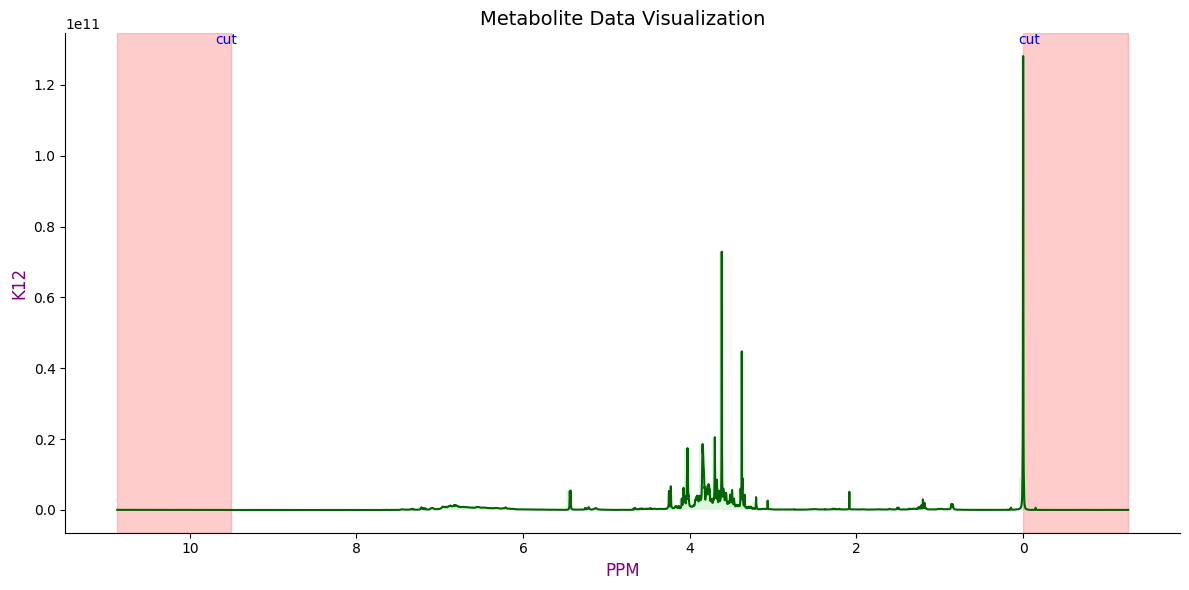

In [70]:
visualize_metabolite_data(ppm_values, X_data, sample_index=0)

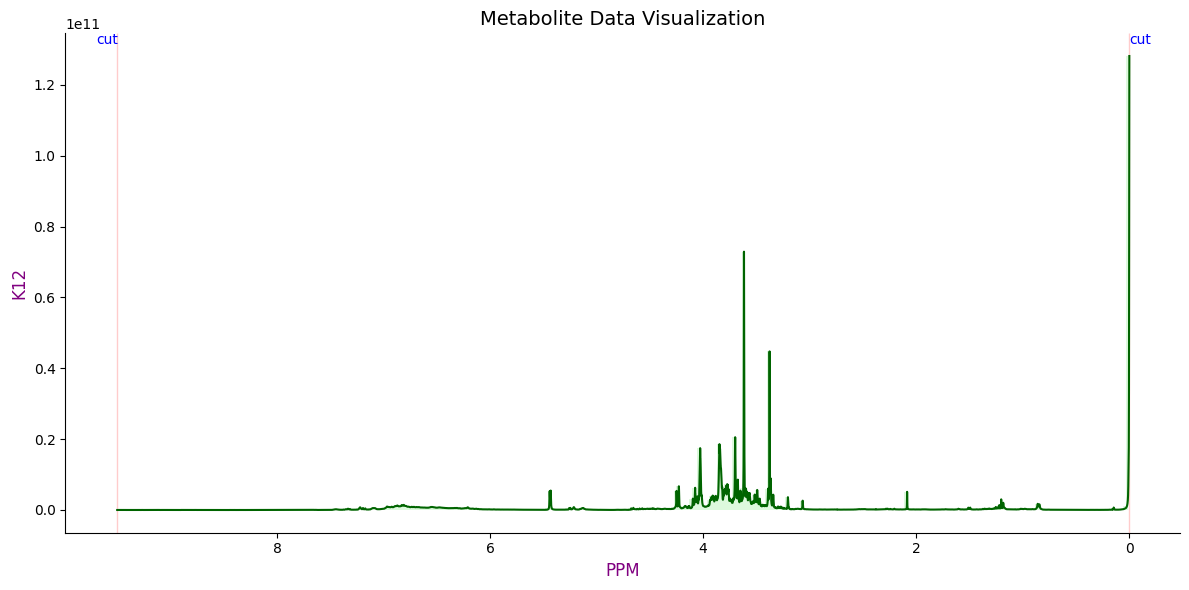

In [71]:
visualize_metabolite_data(ppm_values_filtered, X_data_filtered, sample_index=0)

> 2 quantize ข้อมูลโดยลดจำนวนข้อมูล ให้เหลือเพียง 51 x 400 โดยรวมข้อมูลที่อยู่ข้างกันและเลือกค่า max X

In [82]:
def visualize_metabolite_comparison(ppm_values_original, X_data_original, ppm_values_quantized, X_data_quantized):
    """
    Visualize the comparison between original and quantized metabolite data.

    Parameters:
    ppm_values_original (numpy.ndarray): Original ppm values
    X_data_original (numpy.ndarray): Original X data of shape (51, n_features)
    ppm_values_quantized (numpy.ndarray): Quantized ppm values
    X_data_quantized (numpy.ndarray): Quantized X data of shape (51, 400)
    """
    # Calculate the max values across all samples for both original and quantized data
    max_values_original = np.max(X_data_original, axis=0)
    max_values_quantized = np.max(X_data_quantized, axis=0)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(14, 8))

    # Plot the original data
    ax.plot(ppm_values_original, max_values_original, color='blue', alpha=0.5, linewidth=1, label='Before grouped')

    # Plot the quantized data
    ax.bar(ppm_values_quantized, max_values_quantized,
           width=(ppm_values_quantized[0]-ppm_values_quantized[1]),
           color='lightgreen', edgecolor='darkgreen', alpha=0.7)
    ax.plot(ppm_values_quantized, max_values_quantized, color='darkgreen', linewidth=2, label='After grouped')

    # Customize the plot
    ax.set_xlabel('PPM', color='purple', fontsize=12)
    ax.set_ylabel('K12', color='purple', fontsize=12)
    ax.set_title('Number of data that have been grouped and selected Max', fontsize=14)

    # Invert x-axis to match the example
    ax.invert_xaxis()

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    # Add legend
    ax.legend(loc='upper right')

    plt.tight_layout()

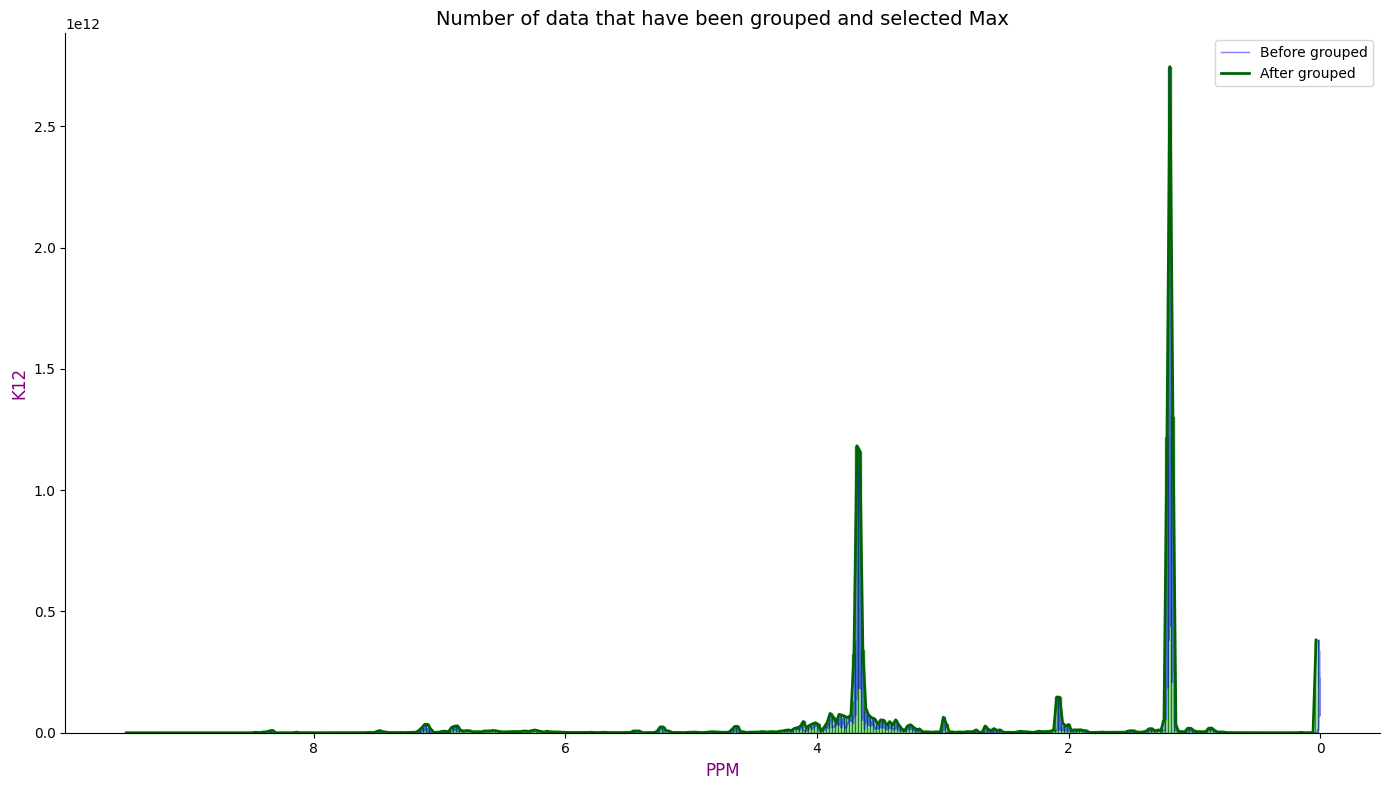

In [83]:
# Now visualize the comparison
visualize_metabolite_comparison(ppm_values_filtered, X_data_filtered, ppm_values_quantized, X_data_quantized)

# 1) ทำ PCA ข้อมูลเพื่อให้สามารถ visualize ได้

In [84]:
# Step 4: Perform PCA
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_data_quantized)

In [85]:
# Print shapes to verify
print("Shape of quantized data:", X_data_quantized.shape)
print("Shape of PCA result:", X_pca.shape)

Shape of quantized data: (51, 400)
Shape of PCA result: (51, 2)


# 2) visualize ข้อมูลทั้ง 51 จุด เพื่อดูการจัดกลุ่มของข้อมูลเบื้องต้น

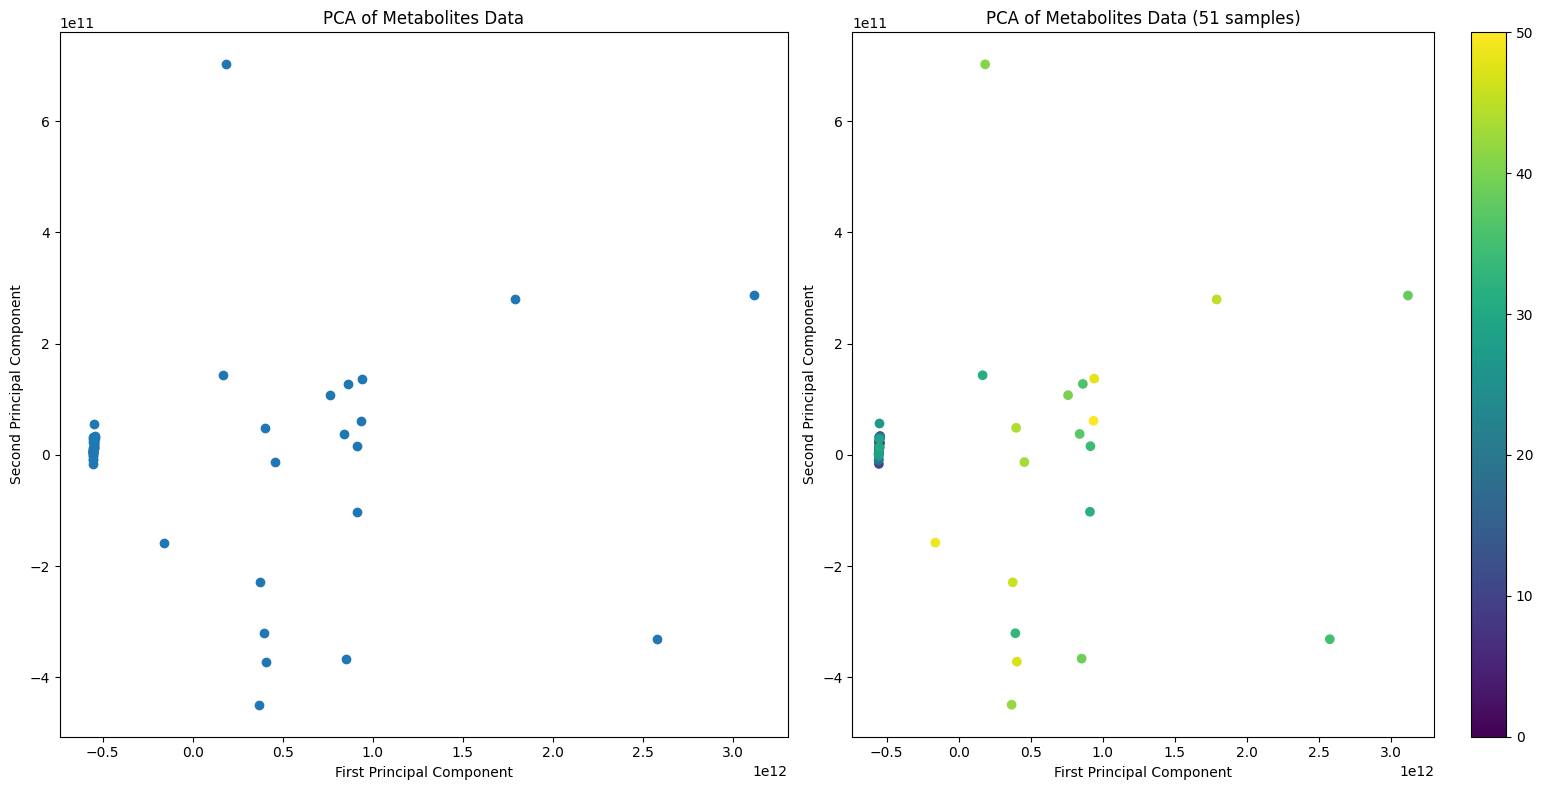

In [87]:
# Create subplots
fig, axes = plt.subplots(1, 2, figsize=(16, 8))

# First subplot: Simple PCA scatter plot
axes[0].scatter(X_pca[:, 0], X_pca[:, 1])
axes[0].set_title('PCA of Metabolites Data')
axes[0].set_xlabel('First Principal Component')
axes[0].set_ylabel('Second Principal Component')

# Second subplot: Colored scatter plot for all 51 samples
scatter = axes[1].scatter(X_pca[:, 0], X_pca[:, 1], c=range(51), cmap='viridis')
axes[1].set_title('PCA of Metabolites Data (51 samples)')
axes[1].set_xlabel('First Principal Component')
axes[1].set_ylabel('Second Principal Component')

# Add color bar
fig.colorbar(scatter, ax=axes[1])

# Show plot
plt.tight_layout()
plt.show()

# 3) ตอบคำถามว่า data มีทั้งหมดกี่กลุ่ม โดย plot จุดข้อมูลแต่ละกลุ่มเป็นคนละสี

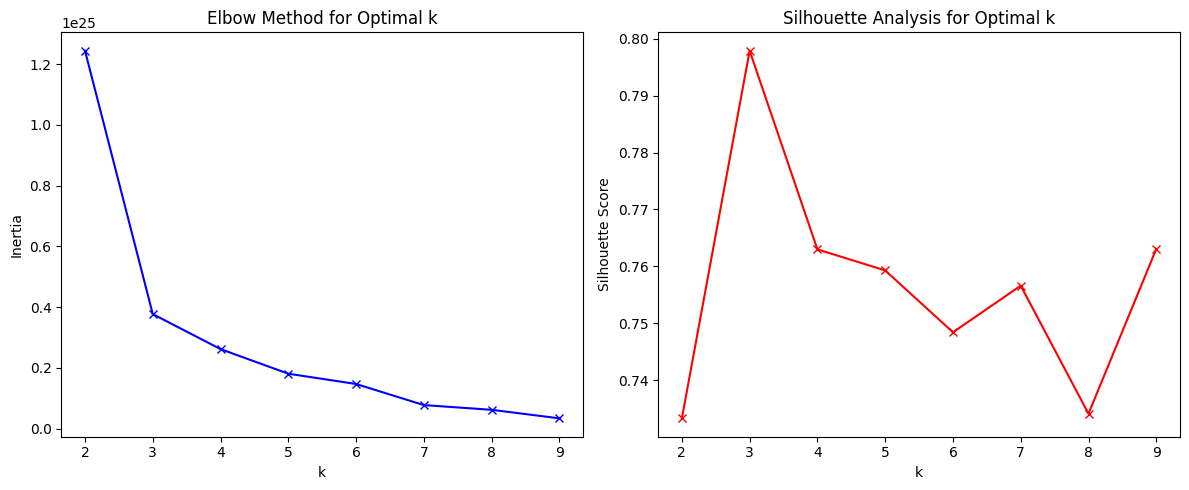

In [92]:
# Elbow method to find optimal number of clusters
inertias = []
silhouette_scores = []
k_range = range(2, 10)

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X_pca)
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(X_pca, kmeans.labels_))

# Plot elbow curve
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(k_range, inertias, 'bx-')
plt.xlabel('k')
plt.ylabel('Inertia')
plt.title('Elbow Method for Optimal k')

plt.subplot(1, 2, 2)
plt.plot(k_range, silhouette_scores, 'rx-')
plt.xlabel('k')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Analysis for Optimal k')
plt.tight_layout()
plt.show()

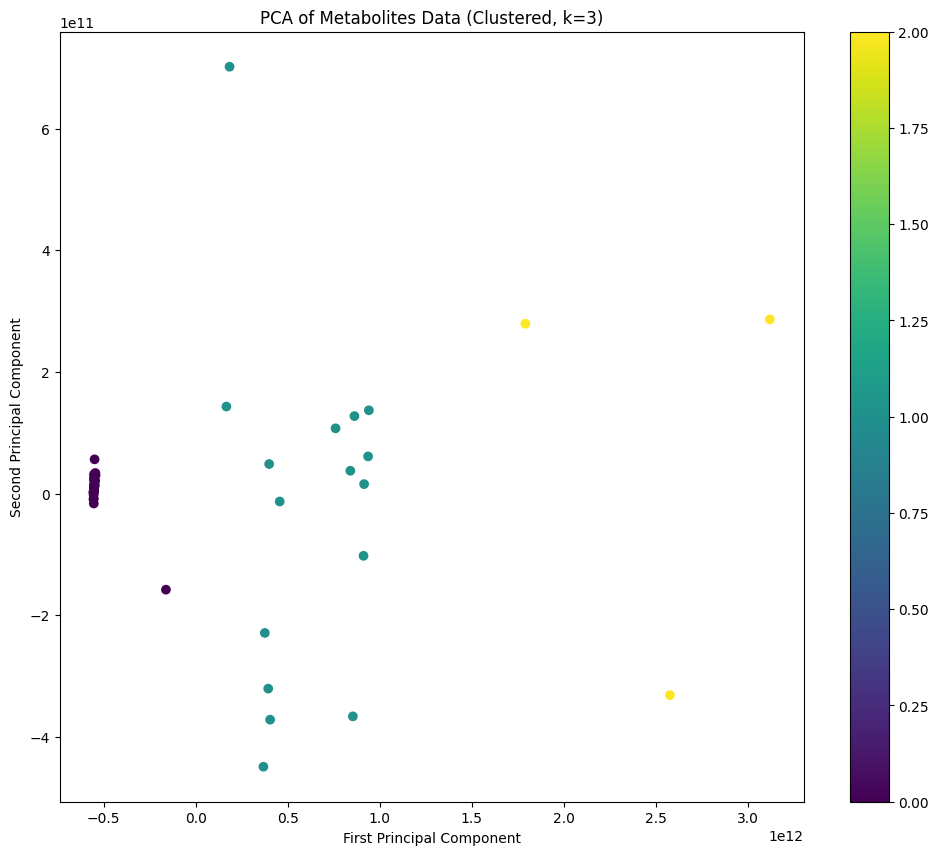

In [93]:
# Choose optimal k based on elbow method and silhouette score
optimal_k = k_range[np.argmax(silhouette_scores)]

# Perform K-means clustering with optimal k
kmeans = KMeans(n_clusters=optimal_k, random_state=42)
cluster_labels = kmeans.fit_predict(X_pca)

# Visualize clusters
plt.figure(figsize=(12, 10))
scatter = plt.scatter(X_pca[:, 0], X_pca[:, 1], c=cluster_labels, cmap='viridis')
plt.colorbar(scatter)
plt.title(f'PCA of Metabolites Data (Clustered, k={optimal_k})')
plt.xlabel('First Principal Component')
plt.ylabel('Second Principal Component')
plt.show()

# 4) สร้าง ตารางที่มี column บอกว่า data แต่ละจุดนั้นอยู่กลุ่มไหน

In [89]:
# Create a table with group assignments
df_groups = pd.DataFrame({
    'Sample': range(1, 52),
    'Group': cluster_labels + 1  # Adding 1 to make groups 1-indexed
})

In [90]:
df_groups

,Sample,Group
0,1,1
1,2,1
2,3,1
3,4,1
4,5,1
5,6,1
6,7,1
7,8,1
8,9,1
9,10,1


In [97]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

def visualize_pca_groups(X_data_quantized):
    """
    Visualize PCA results with different colors for visually distinct groups.

    Parameters:
    X_data_quantized (numpy.ndarray): Quantized X data of shape (51, 400)
    """
    # Perform PCA
    pca = PCA(n_components=2)
    X_pca = pca.fit_transform(X_data_quantized)

    # Create the figure and axis
    fig, ax = plt.subplots(figsize=(12, 10))

    # Define colors for visually distinct groups
    colors = ['red', 'blue', 'green', 'purple', 'orange', 'cyan']

    # Plot each point and let the user interactively select the color
    for i, (x, y) in enumerate(X_pca):
        color = colors[i % len(colors)]  # Cycle through colors
        ax.scatter(x, y, c=color, s=50)
        ax.annotate(str(i+1), (x, y), xytext=(5, 5), textcoords='offset points')

    # Customize the plot
    ax.set_xlabel('First Principal Component', fontsize=12)
    ax.set_ylabel('Second Principal Component', fontsize=12)
    ax.set_title('PCA of Metabolites Data with Visual Grouping', fontsize=14)

    # Remove top and right spines
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    plt.tight_layout()
    plt.show()

    # Ask the user for the number of groups
    n_groups = int(input("Based on the colors in the plot, how many distinct groups do you see? "))

    return n_groups

# Example usage:
# n_groups = visualize_pca_groups(X_data_quantized)
# print(f"The data appears to have {n_groups} distinct groups.")

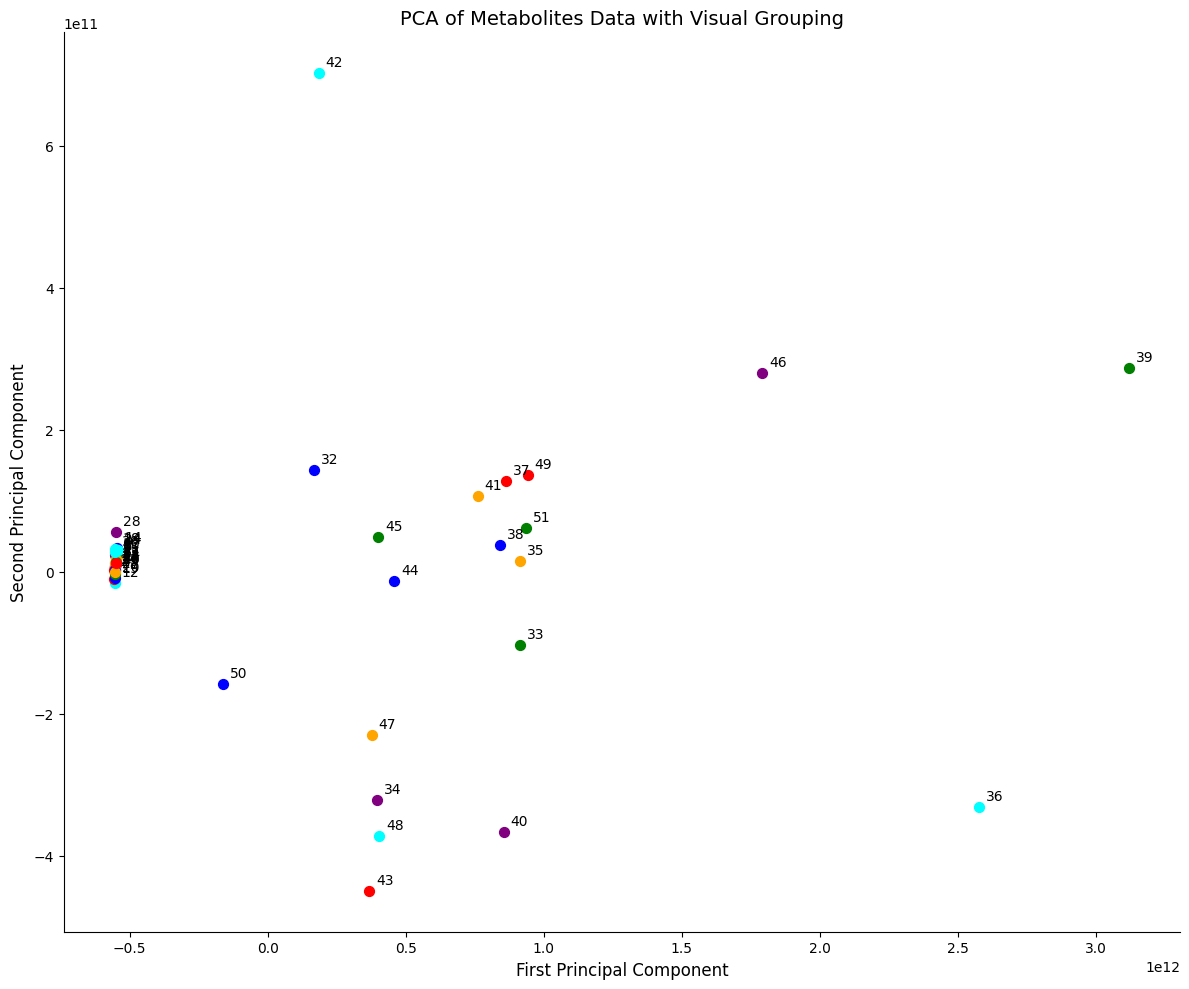

KeyboardInterrupt: Interrupted by user

In [99]:
n_groups = visualize_pca_groups(X_data_quantized)
print(f"The data appears to have {n_groups} distinct groups.")

In [102]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

def simple_group_assignment(X_data_quantized):
    """
    Assign groups to data points based on simple criteria.
    This is a placeholder function - you should replace this with criteria
    that make sense for your specific dataset.
    """
    # Example criteria: group based on the maximum value in each sample
    max_values = np.max(X_data_quantized, axis=1)

    # Define arbitrary thresholds for grouping
    thresholds = np.quantile(max_values, [0.33, 0.67])

    groups = np.digitize(max_values, thresholds)

    return groups

def visualize_grouped_data(ppm_values_quantized, X_data_quantized, groups):
    """
    Visualize the grouped data with each group in a different color.
    """
    fig, ax = plt.subplots(figsize=(14, 8))

    unique_groups = np.unique(groups)
    colors = plt.cm.rainbow(np.linspace(0, 1, len(unique_groups)))

    for group, color in zip(unique_groups, colors):
        mask = groups == group
        ax.plot(ppm_values_quantized, X_data_quantized[mask].T, color=color, alpha=0.5, label=f'Group {group+1}')

    ax.set_xlabel('PPM', color='purple', fontsize=12)
    ax.set_ylabel('K12', color='purple', fontsize=12)
    ax.set_title('Grouped Metabolite Data', fontsize=14)
    ax.invert_xaxis()
    ax.legend()

    plt.tight_layout()
    plt.show()


In [103]:

# Main execution
def group_and_visualize_data(ppm_values_quantized, X_data_quantized):
    # Assign groups
    groups = simple_group_assignment(X_data_quantized)

    # Visualize grouped data
    visualize_grouped_data(ppm_values_quantized, X_data_quantized, groups)

    # Create and display group table
    group_table = create_group_table(groups)
    print(group_table)

    # Return the number of groups
    return len(np.unique(groups))

In [104]:
def create_group_table(groups):
    """
    Create a table showing which group each data point belongs to.
    """
    df = pd.DataFrame({
        'Sample': range(1, len(groups) + 1),
        'Group': groups + 1  # Adding 1 to make groups 1-indexed
    })
    return df

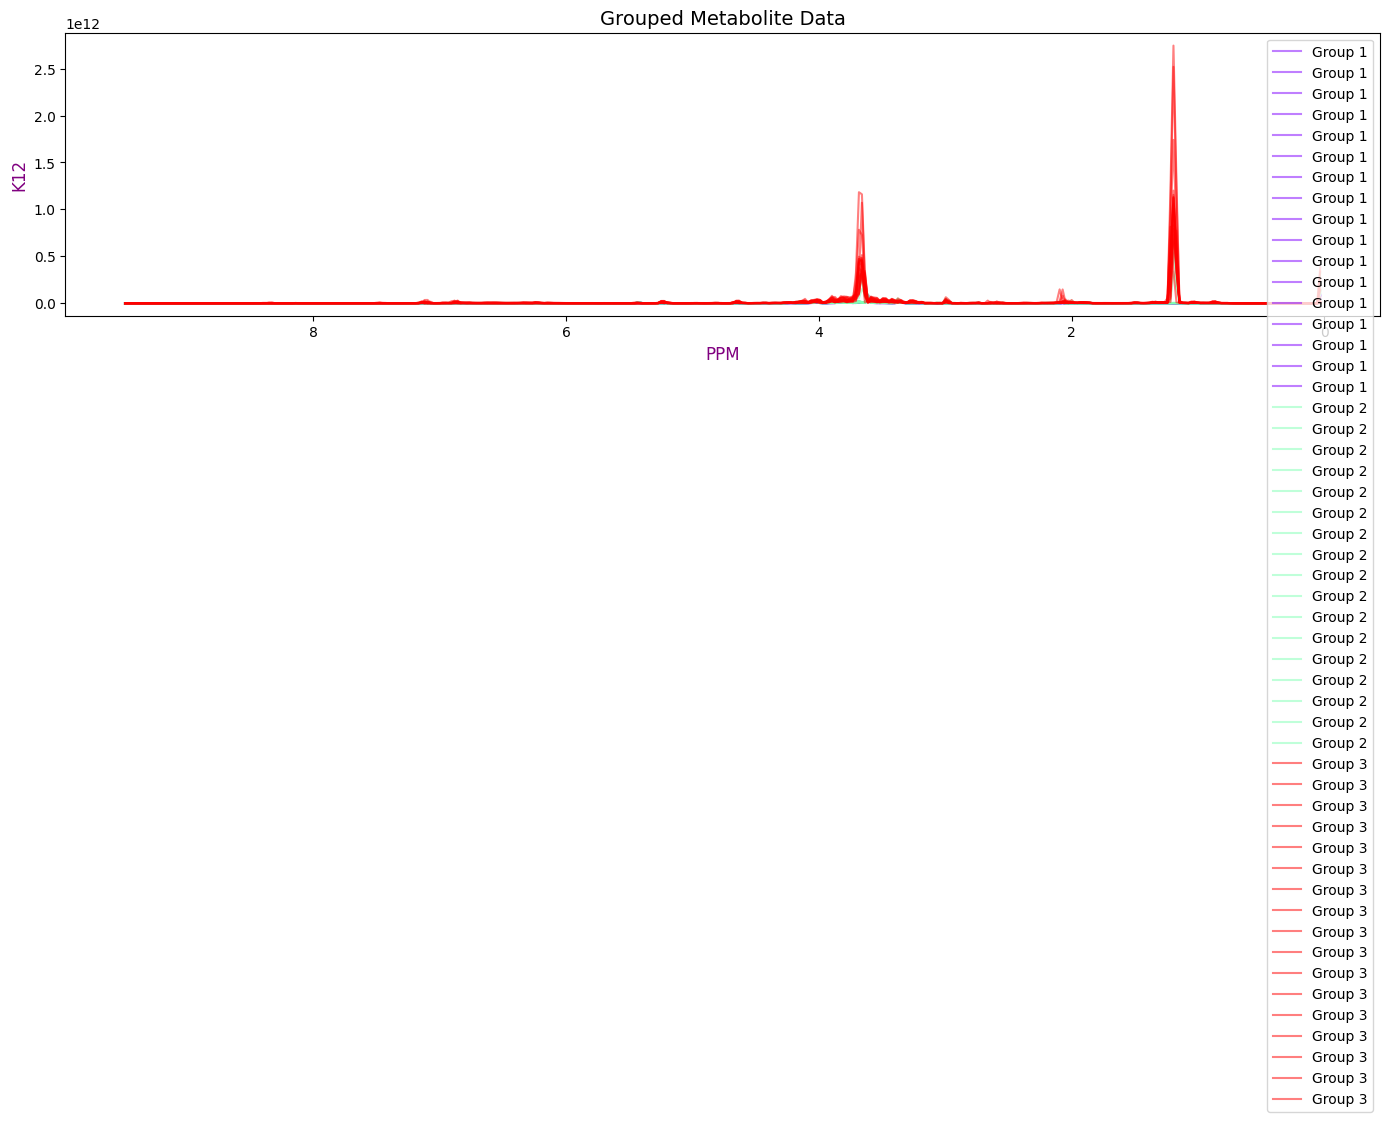

    Sample  Group
0        1      2
1        2      2
2        3      1
3        4      1
4        5      2
5        6      1
6        7      1
7        8      2
8        9      2
9       10      2
10      11      2
11      12      1
12      13      1
13      14      2
14      15      1
15      16      1
16      17      2
17      18      2
18      19      1
19      20      1
20      21      2
21      22      1
22      23      1
23      24      2
24      25      1
25      26      1
26      27      1
27      28      2
28      29      1
29      30      2
30      31      1
31      32      2
32      33      3
33      34      3
34      35      3
35      36      3
36      37      3
37      38      3
38      39      3
39      40      3
40      41      3
41      42      3
42      43      3
43      44      3
44      45      2
45      46      3
46      47      3
47      48      3
48      49      3
49      50      2
50      51      3
The data has been divided into 3 groups.


In [105]:
num_groups = group_and_visualize_data(ppm_values_quantized, X_data_quantized)
print(f"The data has been divided into {num_groups} groups.")